# Training and testing of objection detection network
Based on Faster-RCNN and this guide: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html


In [1]:
# %%shell
#pip install cython
# # Install pycocotools, the version by default in Colab
# # has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
#pip install pycocotools -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

## Importing libraries and custom scripts


In [2]:
import sys
import os
import numpy as np
import torch
import torch.utils.data

# Cloning git repo

!git clone https://github.com/jonasbrondum/02456-project.git


fatal: destination path '02456-project' already exists and is not an empty directory.


In [3]:
import os
os.getcwd()
sys.path.append(os.getcwd() + "/02456-project/scripts_colab")
sys.path.append(os.getcwd() + "/02456-project")


## Dataset class with new __getitem__ function

In [4]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import scripts_colab.transforms as T






class CansDataset(torch.utils.data.Dataset):
    def __init__(self, root, train=True):
        if train is True:
            self.root = root + "/video1/train/"
        else:
            self.root = root +  "/video1/test/"

        self.imgs = list(sorted(os.listdir(os.path.join(self.root,"frames"))))
        self.bbox = list(sorted(os.listdir(os.path.join(self.root,"boundingboxes"))))
    
    def __getitem__(self, idx):
        # load images and bboxes
        img_path = os.path.join(self.root, "frames", self.imgs[idx])
        bbox_path = os.path.join(self.root, "boundingboxes", self.bbox[idx])
        img = Image.open(img_path).convert("RGB")
        img=np.array(img)
        img=torch.tensor(img)/255
        img=img.permute(2,0,1)

        bbox = []
        label = []
        lines = 0
        iscrowd = []
        with open(bbox_path, 'r') as f:
            for line in f:
                line = line.split(" ")
                id = line[0] # class label, 1=beer, 2=cola, 0=background
                id = 1 if id == 'beer' else 2
                xmin = float(line[1])
                ymin = float(line[2])
                xmax = float(line[3])
                ymax = float(line[4])
                bbox.append([xmin, ymin, xmax, ymax])
                label.append(id)
                lines += 1
                iscrowd.append(False)

        bbox = torch.as_tensor(bbox, dtype=torch.int64)
        labels = torch.as_tensor(label, dtype=torch.int64) 
        image_id = torch.tensor([idx],dtype=torch.int64)
        area = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)


        target = {}
        target["boxes"] = bbox
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # if no boxes
        # torch.zeros((0,4), dtype=torch.float32)




        return img, target

    def __len__(self):
        return len(self.imgs)

## Adding pretrained model and modify numbers of classes

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a model pre-trained pre-trained on COCO
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 3  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


## Load data

In [6]:
from scripts_colab.engine import train_one_epoch, evaluate

import scripts_colab.utils
import scripts_colab.transforms as T
from typing import List, Tuple



root = os.getcwd() + "/02456-project/data"

dataset = CansDataset(root, train=True)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=scripts_colab.utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)


print(images[0])

targets = [{k: v for k, v in t.items()} for t in targets]

output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions
print(predictions)


tensor([[[0.3686, 0.4000, 0.3725,  ..., 0.2824, 0.2863, 0.2902],
         [0.3804, 0.3490, 0.3255,  ..., 0.2824, 0.2824, 0.2863],
         [0.3804, 0.3255, 0.3412,  ..., 0.2824, 0.2824, 0.2863],
         ...,
         [0.1098, 0.1098, 0.1098,  ..., 0.0784, 0.0824, 0.0824],
         [0.1059, 0.1059, 0.1059,  ..., 0.0784, 0.0784, 0.0824],
         [0.0980, 0.1020, 0.1020,  ..., 0.0784, 0.0784, 0.0824]],

        [[0.3020, 0.3333, 0.3059,  ..., 0.2392, 0.2471, 0.2510],
         [0.3137, 0.2824, 0.2588,  ..., 0.2392, 0.2431, 0.2471],
         [0.3137, 0.2588, 0.2784,  ..., 0.2431, 0.2431, 0.2471],
         ...,
         [0.1137, 0.1137, 0.1137,  ..., 0.0784, 0.0824, 0.0824],
         [0.1098, 0.1098, 0.1098,  ..., 0.0784, 0.0784, 0.0824],
         [0.1020, 0.1059, 0.1059,  ..., 0.0784, 0.0784, 0.0824]],

        [[0.2392, 0.2627, 0.2275,  ..., 0.1529, 0.1490, 0.1529],
         [0.2510, 0.2118, 0.1804,  ..., 0.1529, 0.1451, 0.1490],
         [0.2431, 0.1804, 0.1882,  ..., 0.1451, 0.1451, 0.

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}, {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}]


### Set indices for data

In [7]:
# use our dataset and defined transformations
dataset = CansDataset(root, train=True)
dataset_test = CansDataset(root, train=False)
print("Oriignal dataset lengths are:")
print("training:",len(dataset))
print("test:",len(dataset_test))


# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
indices_test = torch.randperm(len(dataset_test)).tolist()

dataset = torch.utils.data.Subset(dataset, indices)          #indices[:-973])
dataset_test = torch.utils.data.Subset(dataset_test,indices_test) #indices[-200:])

print("Augmented dataset lengths are:")
print("training:",len(dataset))
print("test:",len(dataset_test))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=4,
    collate_fn=scripts_colab.utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=scripts_colab.utils.collate_fn)


Oriignal dataset lengths are:
training: 1273
test: 319
Augmented dataset lengths are:
training: 1273
test: 319


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Set optimizer, learning rate scheduler and device (CPU/GPU)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device:",device)

# our dataset has three classes only - background, beer and coke
num_classes = 3

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

device: cuda


## Start training

In [9]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #if epoch%5 == 0:
    #    evaluate(model, data_loader_test, device=device)  

  


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [  0/255]  eta: 0:04:03  lr: 0.000025  loss: 1.7539 (1.7539)  loss_classifier: 1.3212 (1.3212)  loss_box_reg: 0.3974 (0.3974)  loss_objectness: 0.0340 (0.0340)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 0.9569  data: 0.7096  max mem: 361
Epoch: [0]  [ 10/255]  eta: 0:01:06  lr: 0.000221  loss: 1.7370 (1.7087)  loss_classifier: 1.2256 (1.1980)  loss_box_reg: 0.4796 (0.4921)  loss_objectness: 0.0131 (0.0166)  loss_rpn_box_reg: 0.0022 (0.0021)  time: 0.2717  data: 0.0830  max mem: 508
Epoch: [0]  [ 20/255]  eta: 0:00:55  lr: 0.000418  loss: 1.4196 (1.4914)  loss_classifier: 0.8531 (0.9271)  loss_box_reg: 0.5384 (0.5479)  loss_objectness: 0.0116 (0.0142)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 0.2022  data: 0.0240  max mem: 511
Epoch: [0]  [ 30/255]  eta: 0:00:50  lr: 0.000615  loss: 1.3026 (1.4095)  loss_classifier: 0.5691 (0.7922)  loss_box_reg: 0.6507 (0.6020)  loss_objectness: 0.0105 (0.0130)  loss_rpn_box_reg: 0.0021 (0.0024)  time: 0.1986  data: 0.0273  max mem: 511
Epoc

## Evaluate model

In [10]:
evaluate(model, data_loader_test, device=device)

creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test:  [  0/319]  eta: 0:01:43  model_time: 0.0588 (0.0588)  evaluator_time: 0.0029 (0.0029)  time: 0.3256  data: 0.2619  max mem: 511
Test:  [100/319]  eta: 0:00:11  model_time: 0.0401 (0.0408)  evaluator_time: 0.0014 (0.0015)  time: 0.0490  data: 0.0055  max mem: 511
Test:  [200/319]  eta: 0:00:06  model_time: 0.0413 (0.0409)  evaluator_time: 0.0015 (0.0015)  time: 0.0516  data: 0.0066  max mem: 511
Test:  [300/319]  eta: 0:00:00  model_time: 0.0386 (0.0407)  evaluator_time: 0.0014 (0.0015)  time: 0.0473  data: 0.0057  max mem: 511
Test:  [318/319]  eta: 0:00:00  model_time: 0.0388 (0.0405)  evaluator_time: 0.0015 (0.0015)  time: 0.0462  data: 0.0056  max mem: 511
Test: Total time: 0:00:16 (0.0502 s / it)
Averaged stats: model_time: 0.0388 (0.0405)  evaluator_time: 0.0015 (0.0015)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.50      | area=   all | 

In [11]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [12]:
prediction

[{'boxes': tensor([[189.5165, 267.9551, 258.8890, 361.9461],
          [260.7003, 310.4362, 345.6035, 366.6057],
          [254.5098, 313.1234, 344.8268, 364.9058]], device='cuda:0'),
  'labels': tensor([1, 1, 2], device='cuda:0'),
  'scores': tensor([0.9811, 0.9344, 0.1160], device='cuda:0')}]

### Helper function for plotting

In [13]:
# Plotting code
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## Display results

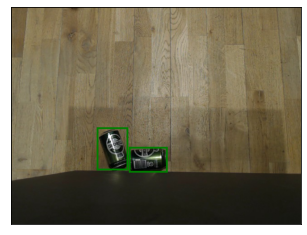

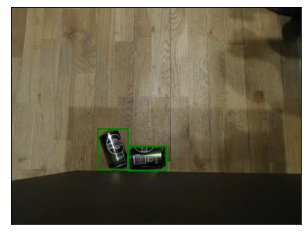

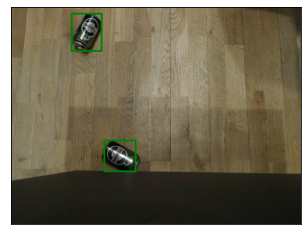

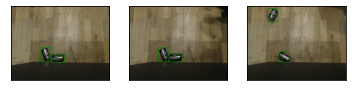

In [14]:
score_threshold = .8
cans_with_boxes = []
model.eval()
ALL_TEST_IMAGES = len(dataset_test)
HALF_TEST_IMAGES = ALL_TEST_IMAGES/2
THREE_IMAGES = 3
for i in range(THREE_IMAGES):
    img, _ = dataset_test[i]

    with torch.no_grad():
        output = model([img.to(device)])[0] # prediction
        img = img.mul(255).type(torch.uint8) # Bring to 0-255 from 0-1 and convert to usable type

        # extract boxes and scores for each color box
        green_boxes = {'boxes':output['boxes'][output['labels']==1],  'scores': output['scores'][output['labels']==1]}
        red_boxes =   {'boxes':output['boxes'][output['labels']==2],  'scores': output['scores'][output['labels']==2]}
        

        # only extract valid boxes
        valid_green_boxes = green_boxes['boxes'][green_boxes['scores'] > score_threshold]
        valid_red_boxes = red_boxes['boxes'][red_boxes['scores'] > score_threshold]

        # concat to one torch array
        boxes = torch.cat((valid_green_boxes, valid_red_boxes),0)

        # Add correct number of green and red boxes
        colors = [len(valid_green_boxes)*['green'], len(valid_red_boxes)*['red']]
        colors = [item for sublist in colors for item in sublist] # flatten list


        # Prepare for plotting
        draw = torchvision.utils.draw_bounding_boxes(img, boxes,colors=colors, width=4)
        show(draw)
        cans_with_boxes.append(draw)



        

# all in one plot
show(cans_with_boxes)

# SAVING MODEL

In [15]:
torch.save(model, "02456-project/model.pth")

Remember to download it afterwards. \
If its any good, upload it to the repo under /models
with a descriptive name